# Quick recap

Last time (first benkyoukai) I have shown my toying with a layer that discovers which activation should it use to represent the data well. It was suggested that the layer may be used to discover useful features in the data. Therefore I want to apply this layer to the blood dataset

# The layer

The feature selection layer was based on an experiment I performed. Generally the layer applies different non-linear operators and chooses the best one via softmax.

In [74]:
# Feature selection layer


import keras.backend as K
from keras.layers import InputSpec, Layer, initializers, regularizers, constraints

class FeatureSelectionLayer(Layer):

    _default_transforms = [
        lambda x: x,
        lambda x: K.pow(x, 2),
        lambda x: K.pow(x, 3),
#        K.exp,
#        K.sqrt,
        K.sin,
        K.tanh
    ]

    def __init__(self,
                 transforms=None,
                 initializer='glorot_uniform',
                 regularizer='adaptive',
                 constraint=None,
                 **kwargs):
        super(FeatureSelectionLayer, self).__init__(**kwargs)
        self.transforms = transforms if transforms is not None else self._default_transforms
        self.initializer = initializers.get(initializer)
        self.regularizer = regularizers.get(regularizer) if regularizer != 'adaptive' else 'adaptive'
        self.constraint = constraints.get(constraint)

    def build(self, input_shape):
        """
        This has to add weights to the layer via self.add_weight
        Also, test input shape and produce self.input_spec
        finally, self.built=True
        """
        output_dim = input_shape[-1]
        activation_dim = len(self.transforms) * input_shape[-1]
        if self.regularizer == 'adaptive':
            self.regularizer = regularizers.L1L2(l1=(0.01 / activation_dim))
        self.kernel = self.add_weight(shape=(output_dim, len(self.transforms)),
                                      initializer=self.initializer,
                                      name='fskernel',
                                      regularizer=self.regularizer,
                                      constraint=self.constraint)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: output_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape
        assert input_shape[-1]
        return tuple(input_shape) # this layer does not change shape, it's learnable activation

    def call(self, inputs):
        """
        this produces a single tensor that is an output of the calculation
        it would be good to apply L1 loss here to actually SELECT features
        """
        activations = [transform(inputs) for transform in self.transforms]
        stacked = K.stack(activations, axis=-1)
        output = K.sum(stacked * self.kernel, axis=-1)
        return output

    def get_config(self):
        base = super(FeatureSelectionLayer, self).get_config()
        conf = {}
        return dict(list(base.items()) + list(conf.items()))

# The data

I will use some random features from quite large dataset of blood data samples. Unfortunately I have no idea what to expect from this dataset, therefore some basic analysis of the dataset contents should be done

In [6]:
import pandas as pd
df = pd.read_csv("bloody_data.csv")  # TBD: Dataset to Drive

/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,2,4,15,16,17,19,20,21,22,23,215,275,291,318,319,321) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# lots of columns, lots of NaNs, let's choose only relevant columns for some case

numerical = ['PCB156 (ng/g)',
 'b-cryptoxanthin(ug/dL)',
 'LBDBANO_0',
 '1,2,3,7,8,9-Hexachlorodibenzofuran (hxcdf) Lipid Adjusted',
 'Molybdenum, urine (ng/mL)',
 'Segmented neutrophils number',
 '2,3,7,8-Tetrachlorodienzo-p-dioxin (tcdd) Lipid Adjusted',
 'PCB118 Lipid Adjusted',
 '1,2,3,4,7,8-Hexachlorodibenzo-p-dioxin (hxcdd)(fg/g)',
 'White blood cell count (1000 cells/uL)',
 'Thyroglobulin',
 'Eosinophils number',
 "3,3',4,4',5,5'-hexachlorobiphenyl (hxcb) Lipid Adjusted",
 'Anti-Mullerian Hormone (ng/ml)',
 'PCB149 (ng/g)',
 'Coffee/tea fast time (hours)\n',
 'PCB157 Lipid Adjusted',
 'CD4 counts (cells/mm3)',
 '1-pyrene (ng/L)',
 'Gamma-hexachloro-cyclohexane (ng/g)',
 'MCHC (g/dL)',
 'Phthalate Subsample 2 year Mec Weight\n',
 'PCB189 Lipid Adjusted',
 'Thyroid hormones Subsample 4 yr Mec Wgt ',
 'TELOSTD',
 'Iron, frozen (umol/L)',
 'Vitamin D (nmol/L)',
 'Transferrin saturation (%)',
 'Mono-isononyl phthalate (ng/mL)',
 'LBXRDW_0',
 'PCB177 Lipid Adjusted',
 'alpha-tocopherol(ug/dL)',
 'Daidzein (ng/mL)',
 'Metolachlor mercapturate (ug/L) result',
 'Follicle stimulating hormone (IU/L)',
 'PCB172 (ng/g)',
 'The time (in minutes) between when the examinee last ate or drank anything other than water and the time of the venipuncture.',
 'Osmolality: SI (mmol/Kg)',
 'Blood Ethylbenzene Result (ng/mL)',
 'Inhibin B (pg/ml)',
 'Aldrin',
 'Plasma glucose (mg/dL)',
 'Uric acid (umol/L)',
 '1,2,3,7,8,9-Hexachlorodibenzo-p-dioxin (hxcdd) Lipid Adjusted',
 'Gum, mints, cough fast time (minutes)\n',
 '1,2,3,4,6,7,8-Heptachlorodibenzofuran (hpcdf) (fg/g)',
 'Total Calcium (mg/dL)',
 'SSCMVOD_0',
 '2-napthol',
 'LBXTC_0',
 'Aspartate aminotransferase (U/L)',
 'b-cryptoxanthin(umol/L)',
 'Enterodiol (ng/mL)',
 'Creatinine (umol/L)\n',
 'PCB177 (ng/g)',
 'Free T4',
 'cis-beta-carotene(umol/L)',
 'alpha-tocopherol(umol/L)',
 'Mono-(3-carboxypropyl) phthalate',
 '1,2,3,4,6,7,8,9-Octachlorodibenzofuran (ocdf) (fg/g)',
 'Thyroperoxidase antibody',
 'Oxychlordane (ng/g)',
 '3,5,6-trichloropyridinol (ug/L) result',
 'PCB153 (ng/g)',
 'PCB167 (ng/g)',
 "p,p'-DDT (ng/g)",
 'PCB87 (ng/g)',
 'Mono-(2-ethyl-5-hydroxyhexyl) phthalate',
 '2,3,7,8,-Tetrachlorodibenzofuran (tcdf)  (fg/g)',
 'Follicle stimulating hormone (IU/L)\n',
 'How old {were you/was SP} when {you were/he was} first told that {you/he} had prostate cancer?',
 'Total protein (g/dL)',
 'Toxoplasma (IgM)',
 'Luteinizing hormone (IU/L)\n',
 'VOC subsample 2 yr MEC Weight',
 'Beryllium, urine (ng/mL)',
 'The time (in hours) between when the examinee last ate or drank anything other than water and the time of the venipuncture.',
 'Glucose, serum (mg/dL)',
 'PCB151 Lipid Adjusted',
 '2,3,4,6,7,8,-Hexchlorodibenzofuran (hxcdf) Lipid Adjusted',
 '1,2,3,4,6,7,8-Heptachlororodibenzo-p-dioxin (hpcdd) (fg/g)',
 'alpha-carotene(umol/L)',
 'Beta',
 'Sex Hormone Binding Globulin (nmol/L)',
 '1,2,3,4,7,8-Hexachlorodibenzo-p-dioxin (hxcdd) Lipid Adjusted',
 'a-carotene(umol/L)',
 '1,2,3,6,7,8-Hexachlorodibenzofuran (hxcdf) (fg/g)',
 'Uranium, urine (ng/mL)',
 'PCB87 Lipid Adjusted',
 '1,2,3,4,7,8-Hexachlorodibenzofuran (hcxdf) Lipid Adjusted',
 'Alcohol fast time (minutes)\n',
 'Mono-n-butyl phthalate (ng/mL)',
 'trans-beta-carotene(umol/L)',
 'Gamma-hexachlorocyclohexane Lipid Adjusted',
 'Platelet count (1000 cells/uL)',
 'Thyroxine (T4) (ug/dL)',
 '1-phenanthrene (ng/L)',
 'beta-cryptoxanthin(umol/L)',
 'PCB99 Lipid Adjusted',
 'PCB189 (ng/g)',
 'Specimen Index ratio',
 'Total T3',
 'Blood Toluene Result (ng/mL)',
 '2,3,7,8,-Tetrachlorodibenzofuran (tcdf) Lipid Adjusted',
 'Gum, mints cough drops fast time (hours)\n',
 'Equol (ng/mL)',
 'PCB138 Lipid Adjusted',
 'Blood m-/p-Xylene Result (ng/mL)',
 'LBXMPSI_0',
 'PEL_Impression',
 'Heavy Metal Subsample 4 Year Mec Weight\n',
 '1,2,3,4,7,8-Hexachlorodibenzofuran (hcxdf) (fg/g)',
 '3-phenanthrene (ng/L)',
 'LBXBAPCT_0',
 'PCB52 (ng/g)',
 'LBXLYPCT_0',
 'beta-cryptoxanthin(ug/dL)',
 'PCB52 Lipid Adjusted',
 'PCB199 Lipid Adjusted',
 'g-tocopherol(umol/L)',
 'Total cholesterol (mmol/L)\n',
 'Endrin Lipid Adjusted',
 'Testostosterone (ng/mL)',
 'Alcohol fast time (hours)\n',
 'Toxoplasma (IgG)',
 'Glucose, serum (mmol/L)',
 'Protein, total (g/dL)',
 'Mercury, inorganic (ug/L)',
 'Thallium, urine (ng/mL)',
 'Mono-n-octyl phthalate (ng/mL)',
 '1,2,3,7,8-Pentachlorodibenzo-p-dioxin (pncdd) Lipid Adjusted',
 'WTSAF2YR_0',
 '1,2,3,4,6,7,8,9-Octachlorodibenzofuran (ocdf) Lipid Adjusted',
 'Sodium (mmol/L)',
 'Oxypyrimidine (ug/L) result',
 'Thyroid stimulating hormone',
 'PCB187 (ng/g)',
 'N-Telopeptides (nmol BCE)',
 '2,3,7,8-Tetrachlorodienzo-p-dioxin (tcdd) (fg/g)',
 'LBDHDL_0',
 '1,2,3,4,6,7,8,9-Octachlorodibenzo-p-dioxin (ocdd) Lipid Adjusted',
 'cis-b-carotene(umol/L)',
 'SS3ADLG',
 '3-fluorene (ng/L)',
 'K/L Ratio',
 'alpha-carotene(ug/dL)',
 'Thyroid hormones Subsample 2 yr Mec Wgt ',
 'LBDLYMNO_0',
 'Floor result in micrograms per square feet by graphite furnace atomic absorption spectrophotometric method.',
 '2-isopropoxyphenol (ug/L) result',
 'PCB105 Lipid Adjusted',
 'Carbofuranphenol (ug/L) result',
 'IF_Result',
 "o,p'-DDT Lipid Adjusted",
 'PCB153 Lipid Adjusted',
 'LBDEONO_0',
 'Albumin/Gamma',
 'HDL-cholesterol (mg/dL)\n',
 'Globulin (g/L)\n',
 'Tungsten, urine (ng/mL)',
 'Blood Trichloroethene Result (ng/mL)',
 'LBXEOPCT_0',
 'Iron, frozen (ug/dL)',
 'Continuous variable describing urinary concentration of nitrate (NO3) (ug/L). Limit of detection: 700 ug/L.',
 'PCB195 (ng/g)',
 'Phosphorus (mg/dL)',
 'DEET (ug/L)',
 'LBXRBCSI_0',
 "3,3',4,4',5-Pentachlorobiphenyl (pncb) (fg/g)",
 'Iodine, urine (ng/mL)',
 'Blood Bromoform Result (pg/mL)',
 'Blood Chloroform Result (pg/mL)',
 'Bicarbonate: SI (mmol/L)',
 'Lead, urine (ng/mL)',
 'LBXMC_0',
 'PCB138 (ng/g)',
 '1,2,3,7,8,9-Hexachlorodibenzofuran (hxcdf) (fg/g)',
 '3-chloro-7-hydroxy-4-methyl-2H-chromen-2-one/ol',
 'LBDNENO_0',
 'LBDTCSI_0',
 '1,2,3,4,7,8,9-Heptachlorodibenzofuran  (Hpcdf) (fg/g)',
 'Mono-benzyl phthalate (ng/mL)',
 'Floor result in micrograms per square feet by flame atomic absorption spectrophotometric method.',
 '2,3,4,7,8-Pentachlorodibenzofuran (pncdf) Lipid Adjusted',
 'Thyroxine (T4) (nmol/L) ',
 'Chloride: SI (mmol/L)',
 'Blood Carbon Tetrachloride Result (ng/mL)',
 'Blood 1,4-Dichlorobenzene Result (ng/mL)',
 'PCB74 (ng/g)',
 'Trans-nonachlor Lipid Adjusted',
 'Mono-(2-ethyl)-hexyl phthalate (ng/mL)',
 'Rubella',
 'C-peptide: pmol/mL',
 'Paranitrophenol (ug/L) result',
 'PCB110 (ng/g)',
 'Sodium: SI (mmol/L)',
 'CD8 counts (cells/mm3)',
 '1,2,3,4,6,7,8,9-Octachlorodibenzo-p-dioxin (ocdd) (fg/g)',
 'PCB183 Lipid Adjusted',
 'Mirex Lipid Adjusted',
 'PCB206 (ng/g)',
 'cis-3-(2,2-dichlorovinyl)-2,2-dimethylcyclopropane carboxylic acid',
 'Alanine aminotransferase (U/L)',
 'Platinum, urine (ng/mL)',
 'PCB149 Lipid Adjusted',
 '2,3,4,7,8-Pentachlorodibenzofuran (pncdf) (fg/g)',
 'Dietary supplements fast time (minutes)\n',
 'PCB178 (ng/g)',
 'Erythrocyte protoporphyrin (umol/L RBC)',
 'WTUIO2YR_0',
 'Bicarbonate (mmol/L)',
 'PCB183 (ng/g)',
 'Glucose, serum (mmol/L)\n',
 'Luteinizing hormone (IU/L)',
 'PCB206 Lipid Adjusted',
 'Blood Tetrachloroethene Result (ng/mL)',
 'Acetochlor mercapturate\n',
 'Potassium (mmol/L)',
 'Lymphocyte number',
 'VOC subsample 4 yr MEC Weight',
 'PCB99 (ng/g)',
 'Heptachlor Epoxide Lipid Adjusted',
 "o,p'-DDT (ng/g)",
 'TELOMEAN',
 'Lambda FLC',
 "p,p'-DDE Lipid Adjusted",
 'a-carotene(ug/dL)',
 '4Yr AM(3-11)  &amp; fasting (12+) weights',
 'PCB66 (ng/g)',
 'PCB180 Lipid Adjusted',
 'Endrin',
 'Water Methyl tert. butyl ether (MTBE) Result (ng/mL)',
 'trans-beta-carotene(ug/dL)',
 'LBXNEPCT_0',
 'Mono-ethyl phthalate (ng/mL)',
 'CMV optical density from ELISA',
 '2-fluorene (ng/L)',
 '1,2,3,4,6,7,8-Heptachlororodibenzo-p-dioxin (hpcdd) Lipid Adjusted',
 'PCB151 (ng/g)',
 'HDL-cholesterol (mmol/L) ',
 'gamma-tocopherol(ug/dL)',
 'Red blood cell count (million cells/uL)',
 'Dimethylthiophosphate (ug/L) result',
 'Alkaline phosphotase (U/L)',
 '2,3,4,6,7,8,-Hexchlorodibenzofuran (hxcdf) (fg/g)',
 'PCB170 Lipid Adjusted',
 '1,2,3,4,7,8,9-Heptachlorodibenzofuran  (Hpcdf) Lipid Adjusted',
 'Lymphocyte number (1000 cells/uL)',
 'PCB128 Lipid Adjusted',
 'The number of days between the collection of the first and second exam',
 'Erythrocyte protoporphyrin (ug/dL RBC)',
 '1,2,3,4,6,7,8-Heptachlorodibenzofuran (hpcdf) Lipid Adjusted',
 'PCB195 Lipid Adjusted',
 'ALT: SI (U/L)',
 'Glucose (mg/dL)',
 'PCB194 Lipid Adjusted',
 'Phosphorus  (mmol/L)',
 'PCB172 Lipid Adjusted',
 '1,2,3,7,8-Pentachlorodibenzo-p-dioxin (pncdd) (fg/g)',
 'Creatinine (umol/L)',
 'Continuous variable describing urinary concentration of  Thiocyanate (SCN) (ug/L). Limit of detection: 20 ug/L.',
 'Blood Dibromochloromethane Result (pg/mL)',
 'LBXPLTSI_0',
 'Water Bromoform Result (ng/mL)',
 'PCB178 Lipid Adjusted',
 'Molecular Type 1',
 'Heptachlor Epoxide (ng/g)',
 'Rubella antibody (international units)\n',
 'Globulin (g/dL)',
 'N-telopeptides (nmol BCE)',
 "3,4,4',5-Tetrachlorobiphenyl (tcb) Lipid Adjusted",
 'cis-beta-carotene(ug/dL)',
 'Blood Benzene Result (ng/mL)',
 '1,2,3,6,7,8-Hexachlorodibenzo-p-dioxin (hxcdd)(fg/g)',
 'Phthalate Subsample 4 year Mec',
 'Dioxins Subsample 2 Year Mec Weight',
 'Iodine Subsample 2 year Mec Weight',
 'Surplus sera cystatin 99-02 weights',
 'Antacids, laxatives fast time (hours)\n',
 'Mean cell hemoglobin concentration (g/dL)',
 'PCB170 (ng/g)',
 'PCB101 (ng/g)',
 '1,2,3,6,7,8-Hexachlorodibenzofuran (hxcdf) Lipid Adjusted',
 'Window result in micrograms per square feet by flame atomic absorption spectrophotometric method.',
 'Blood o-Xylene Result (ng/mL)',
 'estradiol (pg/mL)',
 "3,3',4,4',5,5'-hexachlorobiphenyl (hxcb) (fg/g)",
 'PCB157 (ng/g)',
 'Alpha1',
 'Cytomegalovirus viral load Copies/mL',
 'LBXWBCSI_0',
 'Water Bromodichloromethane Result (ng/mL)',
 'Oxychlordane Lipid Adjusted',
 'Basophils number',
 'PCB156 Lipid Adjusted',
 'Urinary Perchlorate (ug/L)',
 'Mono-isobutyl pthalate\n',
 'Water Dibromochloromethane Result (ng/mL)',
 'Total_Protein',
 '4-fluoro-3-phenoxybenzoic (ug/L) acid',
 'PCB118 (ng/g)',
 'PCB128 (ng/g)',
 'Total calcium (mg/dL)',
 'Phosphorus  (mg/dL)',
 'HDL-cholesterol (mmol/L)\n',
 'Gamma',
 'PCB146 (ng/g)',
 'Genistein (ng/mL)',
 'Diethyldithiophosphate (ug/L) result',
 'PCB167 Lipid Adjusted',
 'Blood Bromodichloromethane Result (pg/mL)',
 '1-napthol',
 'WTSAF4YR_0',
 '2-phenanthrene (ng/L)',
 'Toxoplasma (Avidity) IgG',
 'Dieldrin (ng/g)',
 'Pesticides Subsample 4 year Mec Weight\n',
 'Dioxins Subsample 4 Year Mec Weight',
 'LBXHCT_0',
 'Enterolactone (ng/mL)',
 'PCB105 (ng/g)',
 'PCB194 (ng/g)',
 'Chloride (mmol/L)',
 'Antimony, urine (ng/mL)',
 'Blood Methyl t-Butyl Ether (MTBE) Result (pg/mL)',
 'PCB187 Lipid Adjusted',
 'Lactate dehydrogenase (U/L)',
 'Triglycerides (mg/dL)',
 'Eosinophils number (1000 cells/uL)',
 'Kappa FLC',
 'Dimethyldithiophosphate (ug/L) result',
 'Mono-n-methyl phthalate',
 'Serum ferritin (ng/ml)\n',
 'PCB196 (ng/g)',
 'Cadmium, urine (ng/mL)',
 'Thyroglobulin antibody',
 'trans-b-carotene(umol/L)',
 'Mercury, urine (ng/mL)\n',
 'Platelet count (%) SI',
 'GGT: SI (U/L)',
 'Coffee/tea fast time (minutes)\n',
 'LBDMONO_0',
 'Dimethylphosphate (ug/L) result',
 'Mirex (ng/g)',
 'LDH (U/L)',
 'Total T4',
 'Hexachlorobenzene (ng/g)',
 'Total protein (g/L)\n',
 'Diethylthiophosphate (ug/L) result',
 'Rubella units',
 'Heavy Metal Subsample 2 Year Mec Weight',
 'Protoporphyrin(µmol/L RBC)',
 'Dietary supplements fast time (hours)\n',
 'PCB101 Lipid Adjusted',
 'PCB66 Lipid Adjusted',
 'AST: SI (U/L)',
 '1,2,3,7,8-Pentachlorodibenzofuran (pncdf) Lipid Adjusted',
 '3-phenoxybenzoic (ug/L) acid result',
 'Alkaline phosphatase (U/L)',
 'LBXMCHSI_0',
 'LBXHGB_0',
 '2,4-D (ug/L) result',
 'Thyroid stimulating hormone (TSH) (IU/L)',
 'Antacids, laxatives fast time (minutes)\n',
 'Beta-hexachlorocyclohexane Lipid Adjusted',
 "p,p'-DDE (ng/g)",
 'Barium, urine (ng/mL)',
 'LBDHDLSI_0',
 'trans-3-(2,2-dichlorovinyl)-2,2-dimethylcyclopropane carboxylic acid',
 '2-(diethylamino)-6-methylpyrimidin-4-ol/one',
 'Potassium: SI (mmol/L)',
 'Atrazine mercapturate (ug/L) result',
 "3,4,4',5-Tetrachlorobiphenyl (tcb) (fg/g)",
 'PCB110 Lipid Adjusted',
 'Free T3',
 'Phosphorus (mmol/L)',
 "3,3',4,4',5-Pentachlorobiphenyl (pncb) Lipid Adjusted",
 '1,2,3,6,7,8-Hexachlorodibenzo-p-dioxin (hxcdd) Lipid Adjusted',
 'Diethylphosphate (ug/L)result',
 'Vitamin E (ug/dL)',
 'gamma-tocopherol(umol/L)',
 'Total iron binding capacity (umol/L)',
 'White blood cell count:  SI',
 'Aldrin Lipid Adjusted',
 'Alpha2',
 '1,2,3,7,8-Pentachlorodibenzofuran (pncdf) (fg/g)',
 'Dieldrin Lipid Adjusted',
 'Hexachlorobenzene Lipid Adjusted',
 'Glucose, plasma (mg/dL)',
 'Mercury, inorganic (umol/L)',
 'Mono-cyclohexyl phthalate (ng/mL)',
 'cis-b-carotene(ug/dL)',
 'Trans-nonachlor (ng/g)',
 'Total cholesterol (mmol/L) ',
 'PCB199 (ng/g)',
 'PCB74 Lipid Adjusted',
 'Monocyte number',
 'Mono-(2-ethyl-5-oxohexyl) phthalate',
 'Water Chloroform Result',
 "p,p'-DDT Lipid Adjusted",
 'Triglycerides (mg/dL) ',
 'Albumin',
 'PCB146 Lipid Adjusted',
 'LBXMOPCT_0',
 'Vitamin E (umol/L)',
 'Size of peak if available',
 'Cystatin C (mg/L)',
 'cis-3-(2,2-dibromovinyl)-2,2-dimethylcyclopropane carboxylic acid',
 'LBXMCVSI_0',
 'Total protein (g/L)',
 'Gamma glutamyltransferase',
 'Red cell count SI',
 'PCB180 (ng/g)',
 'TTG IGA value',
 'Protoporphyrin(ug/dL RBC)',
 'Cesium, urine (ng/mL)',
 '1,2,3,7,8,9-Hexachlorodibenzo-p-dioxin (hxcdd) (fg/g)',
 'Total iron binding capacity (ug/dL)',
 'g-tocopherol(ug/dL)',
 'Cobalt, urine (ng/mL)',
 'HDL-cholesterol (mg/dL) ',
 'PCB196 Lipid Adjusted',
 'Monocyte number (1000 cells/uL)',
 'Blood Styrene Result (ng/mL)',
 'Beta-hexachloro-cyclohexane (ng/g)',
 'Segmented neutrophils num (1000 cell/uL)',
 'trans-b-carotene(ug/dL)',
 'Pesticides Subsample 2 year Mec Weight\n',
 'o-Desmethylangolensin (O-DMA) (ng/mL)',
 'Serum transferrin receptor (mg/l)\n',
 'Uric acid (umol/L)\n',
 '2Yr AM(3-11)  &amp; fasting (12+) weights']

In [13]:
# Let's also trim to examples we want to actually predict

targets = ['Herpes II', 'Herpes I']
subset = df[df[targets[0]].notna() & df[targets[1]].notna()]
subset = subset.reset_index(False).drop("index", 1)
variables = subset[numerical]
targets = subset[targets]

In [39]:
# View whether targets are reasonable

targets = targets.apply(lambda row: str((bool(row[0] - 1), bool(row[1] - 1))), axis=1)
targets

0         (True, True)
1         (True, True)
2        (True, False)
3       (False, False)
4        (True, False)
5        (True, False)
6        (True, False)
7        (True, False)
8        (True, False)
9       (False, False)
10       (True, False)
11       (True, False)
12       (True, False)
13       (False, True)
14       (False, True)
15       (False, True)
16        (True, True)
17      (False, False)
18       (True, False)
19        (True, True)
20       (True, False)
21       (True, False)
22       (True, False)
23       (True, False)
24        (True, True)
25        (True, True)
26       (True, False)
27        (True, True)
28      (False, False)
29       (True, False)
             ...      
3003    (False, False)
3004     (True, False)
3005     (True, False)
3006     (True, False)
3007      (True, True)
3008      (True, True)
3009    (False, False)
3010    (False, False)
3011     (True, False)
3012     (True, False)
3013     (True, False)
3014    (False, False)
3015     (T

In [43]:
# pick some reasonable number of features

series = variables.notna().mean()
series = series.sort_values(ascending=False)
series = series[:75].index
series

Index(['LBDHDL_0', 'Molecular Type 1', 'LBXTC_0',
       'Total cholesterol (mmol/L)\n', 'Toxoplasma (IgG)',
       'HDL-cholesterol (mmol/L)\n', 'HDL-cholesterol (mg/dL)\n', 'LBDTCSI_0',
       'LBDHDLSI_0', 'Vitamin E (umol/L)', 'Vitamin E (ug/dL)',
       'Rubella units', 'LBXPLTSI_0',
       'The time (in minutes) between when the examinee last ate or drank anything other than water and the time of the venipuncture.',
       'Sodium: SI (mmol/L)', 'LBXMPSI_0', 'Platelet count (%) SI',
       'GGT: SI (U/L)', 'LBXRDW_0', 'LDH (U/L)', 'Glucose, serum (mg/dL)',
       'Osmolality: SI (mmol/Kg)', 'LBXHCT_0', 'Total Calcium (mg/dL)',
       'White blood cell count:  SI',
       'The time (in hours) between when the examinee last ate or drank anything other than water and the time of the venipuncture.',
       'AST: SI (U/L)', 'Alkaline phosphatase (U/L)', 'LBXMCHSI_0',
       'Creatinine (umol/L)\n', 'LBXHGB_0', 'Uric acid (umol/L)\n',
       'ALT: SI (U/L)', 'LBXWBCSI_0', 'LBXMCVSI_0',

In [54]:
frame = variables[series].drop("Molecular Type 1", axis=1) # Drop bad column

In [62]:
filterNAs = frame.notna().apply(all, axis=1)
frame = frame[filterNAs]

In [68]:
norm = frame - frame.mean()
norm = norm / norm.std()
norm # normalized features

,LBDHDL_0,LBXTC_0,Total cholesterol (mmol/L),Toxoplasma (IgG),HDL-cholesterol (mmol/L),HDL-cholesterol (mg/dL),LBDTCSI_0,LBDHDLSI_0,Vitamin E (umol/L),Vitamin E (ug/dL),...,LBXMOPCT_0,LBDLYMNO_0,LBXLYPCT_0,LBXBAPCT_0,Basophils number,Eosinophils number,Segmented neutrophils number,LBDMONO_0,LBDBANO_0,Lymphocyte number
0,-1.120806,1.297114,1.299412,-0.314972,-1.108549,-1.120806,1.299412,-1.108549,1.492148,1.492187,...,0.743010,0.247271,-0.815872,0.650790,1.177752,0.612234,0.949062,1.867854,1.177752,0.247271
1,-0.576499,-0.598006,-0.602122,-0.273949,-0.582225,-0.576499,-0.602122,-0.582225,-0.519125,-0.519151,...,1.021949,-0.069312,1.515540,0.419546,-0.648990,0.612234,-1.322379,-0.344523,-0.648990,-0.069312
2,-0.984729,0.001716,0.000804,-0.314972,-0.976968,-0.984729,0.000804,-0.976968,-0.704827,-0.704788,...,0.882480,0.405562,-0.445237,-0.042941,1.177752,1.180220,0.420820,1.867854,1.177752,0.405562
3,2.825421,0.313571,0.316180,-0.294461,2.812560,2.825421,0.316180,2.812560,-0.401372,-0.401402,...,2.416645,-0.227604,-0.062646,-0.042941,-0.648990,-1.091723,-0.371543,1.867854,-0.648990,-0.227604
4,-1.529036,-0.957839,-0.954601,-0.314972,-1.529607,-1.529036,-0.954601,-1.529607,-0.445832,-0.445880,...,0.928970,-1.652227,0.774271,-0.042941,-0.648990,-0.523737,-1.639325,-1.450712,-0.648990,-1.652227
5,0.852308,-1.197727,-1.195772,-0.314972,0.865164,0.852308,-1.195772,0.865164,-1.124725,-1.124753,...,1.393868,0.088979,1.025346,2.500739,1.177752,1.180220,-1.111083,0.208571,1.177752,0.088979
6,-1.324921,-0.933850,-0.936050,-0.314972,-1.319078,-1.324921,-0.936050,-1.319078,0.586521,0.586476,...,0.045662,0.247271,-0.289810,0.419546,1.177752,-0.523737,0.315172,0.208571,1.177752,0.247271
7,-0.644537,-0.621995,-0.620673,-0.314972,-0.634858,-0.644537,-0.620673,-0.634858,-0.722067,-0.722111,...,-0.279766,-1.177352,-0.349589,0.188303,-0.648990,1.180220,-0.741313,-0.897617,-0.648990,-1.177352
8,-1.120806,-0.526039,-0.527916,-0.314972,-1.108549,-1.120806,-0.527916,-1.108549,1.937149,1.937200,...,-0.419236,0.405562,0.296032,0.419546,1.177752,0.044249,-0.160246,-0.344523,1.177752,0.405562
9,-0.848652,-0.358117,-0.360952,0.526015,-0.845387,-0.848652,-0.360952,-0.845387,0.702358,0.702353,...,-1.116584,-0.227604,0.080825,-0.042941,-0.648990,-0.523737,-0.318719,-1.450712,-0.648990,-0.227604


In [73]:
import keras.utils

available = list(set(targets))
target_matrix = keras.utils.to_categorical([available.index(x) for x in targets])
target_matrix = target_matrix[filterNAs]

print(available)
target_matrix

['(True, False)', '(False, False)', '(False, True)', '(True, True)']


array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [81]:
train = 2500
valid = 250

# The baseline

AS the baseline, we will create a basic network with one hidden layer with 1024 units and sigmoid activations (since the task is classification...)

In [114]:
baseline = keras.models.Sequential()
baseline.add(keras.layers.Dense(128, input_shape=(74,), activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l1=3e-5)))
baseline.add(keras.layers.Dense(4, activation='softmax'))
baseline.compile('adam', 'categorical_crossentropy', metrics=['acc'])
hist = baseline.fit(norm[:train], target_matrix[:train],
             epochs=100,
             validation_data=(norm[train:train+valid], target_matrix[train:train+valid]))

Train on 2500 samples, validate on 250 samples
Epoch 1/100
2500/2500 [==============================] - 1s 363us/step - loss: 1.1714 - acc: 0.5196 - val_loss: 1.0656 - val_acc: 0.5600
Epoch 2/100
2500/2500 [==============================] - 0s 113us/step - loss: 1.0933 - acc: 0.5244 - val_loss: 1.0203 - val_acc: 0.5520
Epoch 3/100
2500/2500 [==============================] - 0s 114us/step - loss: 1.0719 - acc: 0.5432 - val_loss: 1.0007 - val_acc: 0.5760
Epoch 4/100
2500/2500 [==============================] - 0s 114us/step - loss: 1.0635 - acc: 0.5392 - val_loss: 1.0039 - val_acc: 0.5440
Epoch 5/100
2500/2500 [==============================] - 0s 114us/step - loss: 1.0591 - acc: 0.5496 - val_loss: 0.9973 - val_acc: 0.5720
Epoch 6/100
2500/2500 [==============================] - 0s 113us/step - loss: 1.0539 - acc: 0.5532 - val_loss: 1.0176 - val_acc: 0.5360
Epoch 7/100
2500/2500 [==============================] - 0s 118us/step - loss: 1.0485 - acc: 0.5528 - val_loss: 1.0201 - val_acc: 0

2500/2500 [==============================] - 0s 117us/step - loss: 0.9002 - acc: 0.6352 - val_loss: 1.0350 - val_acc: 0.5480
Epoch 61/100
2500/2500 [==============================] - 0s 114us/step - loss: 0.8930 - acc: 0.6488 - val_loss: 1.0337 - val_acc: 0.5600
Epoch 62/100
2500/2500 [==============================] - 0s 114us/step - loss: 0.8848 - acc: 0.6572 - val_loss: 1.0273 - val_acc: 0.5600
Epoch 63/100
2500/2500 [==============================] - 0s 116us/step - loss: 0.8823 - acc: 0.6512 - val_loss: 1.0372 - val_acc: 0.5440
Epoch 64/100
2500/2500 [==============================] - 0s 116us/step - loss: 0.8773 - acc: 0.6612 - val_loss: 1.0290 - val_acc: 0.5440
Epoch 65/100
2500/2500 [==============================] - 0s 113us/step - loss: 0.8733 - acc: 0.6600 - val_loss: 1.0408 - val_acc: 0.5560
Epoch 66/100
2500/2500 [==============================] - 0s 113us/step - loss: 0.8665 - acc: 0.6608 - val_loss: 1.0482 - val_acc: 0.5560
Epoch 67/100
2500/2500 [=======================

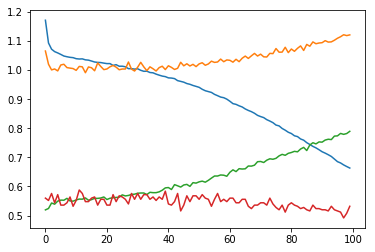

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [125]:
# retrain with 35 epochs

baseline = keras.models.Sequential()
baseline.add(keras.layers.Dense(128, input_shape=(74,), activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l1=3e-5)))
baseline.add(keras.layers.Dense(4, activation='softmax'))
baseline.compile('adam', 'categorical_crossentropy', metrics=['acc'])
hist = baseline.fit(norm[:train], target_matrix[:train],
             epochs=35,
             validation_data=(norm[train:train+valid], target_matrix[train:train+valid]))

Train on 2500 samples, validate on 250 samples
Epoch 1/35
2500/2500 [==============================] - 1s 405us/step - loss: 1.1931 - acc: 0.4740 - val_loss: 1.0084 - val_acc: 0.5800
Epoch 2/35
2500/2500 [==============================] - 0s 108us/step - loss: 1.0838 - acc: 0.5292 - val_loss: 1.0042 - val_acc: 0.5440
Epoch 3/35
2500/2500 [==============================] - 0s 114us/step - loss: 1.0701 - acc: 0.5364 - val_loss: 0.9974 - val_acc: 0.5720
Epoch 4/35
2500/2500 [==============================] - 0s 115us/step - loss: 1.0621 - acc: 0.5444 - val_loss: 1.0172 - val_acc: 0.5440
Epoch 5/35
2500/2500 [==============================] - 0s 112us/step - loss: 1.0566 - acc: 0.5464 - val_loss: 1.0128 - val_acc: 0.5440
Epoch 6/35
2500/2500 [==============================] - 0s 107us/step - loss: 1.0509 - acc: 0.5432 - val_loss: 1.0300 - val_acc: 0.5520
Epoch 7/35
2500/2500 [==============================] - 0s 110us/step - loss: 1.0507 - acc: 0.5460 - val_loss: 1.0065 - val_acc: 0.5360
E

In [126]:
baseline.summary() # get number of weights

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 128)               9600      
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 516       
Total params: 10,116
Trainable params: 10,116
Non-trainable params: 0
_________________________________________________________________


# My model

The feature discovery layer in the first stage will replace Dense in such a way as to retain total number of parameters similar

In [127]:
mine = keras.models.Sequential()
mine.add(FeatureSelectionLayer(input_shape=(74,)))
mine.add(keras.layers.Dense(123, activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l1=3e-5)))
mine.add(keras.layers.Dense(4, activation='softmax'))
mine.compile('adam', 'categorical_crossentropy', metrics=['acc'])
mine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_selection_layer_9 (F (None, 74)                370       
_________________________________________________________________
dense_52 (Dense)             (None, 123)               9225      
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 496       
Total params: 10,091
Trainable params: 10,091
Non-trainable params: 0
_________________________________________________________________


In [128]:
hist = mine.fit(norm[:train], target_matrix[:train],
             epochs=100,
             validation_data=(norm[train:train+valid], target_matrix[train:train+valid]))

Train on 2500 samples, validate on 250 samples
Epoch 1/100
2500/2500 [==============================] - 1s 464us/step - loss: 1.2254 - acc: 0.4772 - val_loss: 1.0532 - val_acc: 0.5560
Epoch 2/100
2500/2500 [==============================] - 0s 130us/step - loss: 1.1146 - acc: 0.5260 - val_loss: 1.0438 - val_acc: 0.5560
Epoch 3/100
2500/2500 [==============================] - 0s 132us/step - loss: 1.0775 - acc: 0.5368 - val_loss: 1.0773 - val_acc: 0.5160
Epoch 4/100
2500/2500 [==============================] - 0s 132us/step - loss: 1.0681 - acc: 0.5448 - val_loss: 1.0246 - val_acc: 0.5320
Epoch 5/100
2500/2500 [==============================] - 0s 131us/step - loss: 1.0587 - acc: 0.5532 - val_loss: 1.0251 - val_acc: 0.5640
Epoch 6/100
2500/2500 [==============================] - 0s 129us/step - loss: 1.0485 - acc: 0.5532 - val_loss: 1.0297 - val_acc: 0.5320
Epoch 7/100
2500/2500 [==============================] - 0s 132us/step - loss: 1.0400 - acc: 0.5656 - val_loss: 1.0275 - val_acc: 0

2500/2500 [==============================] - 0s 133us/step - loss: 0.7280 - acc: 0.7436 - val_loss: 1.1046 - val_acc: 0.5120
Epoch 61/100
2500/2500 [==============================] - 0s 130us/step - loss: 0.7201 - acc: 0.7408 - val_loss: 1.1267 - val_acc: 0.4960
Epoch 62/100
2500/2500 [==============================] - 0s 133us/step - loss: 0.7096 - acc: 0.7536 - val_loss: 1.1249 - val_acc: 0.5040
Epoch 63/100
2500/2500 [==============================] - 0s 132us/step - loss: 0.6969 - acc: 0.7648 - val_loss: 1.1145 - val_acc: 0.5160
Epoch 64/100
2500/2500 [==============================] - 0s 126us/step - loss: 0.6913 - acc: 0.7644 - val_loss: 1.1290 - val_acc: 0.5000
Epoch 65/100
2500/2500 [==============================] - 0s 128us/step - loss: 0.6768 - acc: 0.7720 - val_loss: 1.1481 - val_acc: 0.4920
Epoch 66/100
2500/2500 [==============================] - 0s 132us/step - loss: 0.6664 - acc: 0.7872 - val_loss: 1.1277 - val_acc: 0.4880
Epoch 67/100
2500/2500 [=======================

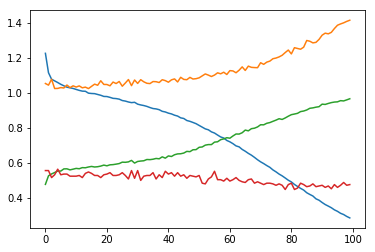

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [132]:
mine = keras.models.Sequential()
mine.add(FeatureSelectionLayer(input_shape=(74,)))
mine.add(keras.layers.Dense(123, activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l1=3e-5)))
mine.add(keras.layers.Dense(4, activation='softmax'))
mine.compile('adam', 'categorical_crossentropy', metrics=['acc'])
hist = mine.fit(norm[:train], target_matrix[:train],
             epochs=5,
             validation_data=(norm[train:train+valid], target_matrix[train:train+valid]))

Train on 2500 samples, validate on 250 samples
Epoch 1/5
2500/2500 [==============================] - 1s 475us/step - loss: 1.2345 - acc: 0.4584 - val_loss: 1.0523 - val_acc: 0.5560
Epoch 2/5
2500/2500 [==============================] - 0s 127us/step - loss: 1.1124 - acc: 0.5304 - val_loss: 1.0204 - val_acc: 0.5600
Epoch 3/5
2500/2500 [==============================] - 0s 130us/step - loss: 1.0827 - acc: 0.5416 - val_loss: 1.0259 - val_acc: 0.5800
Epoch 4/5
2500/2500 [==============================] - 0s 130us/step - loss: 1.0664 - acc: 0.5496 - val_loss: 1.0366 - val_acc: 0.5560
Epoch 5/5
2500/2500 [==============================] - 0s 130us/step - loss: 1.0522 - acc: 0.5624 - val_loss: 1.0093 - val_acc: 0.5600


# Conclusions (so far...)

First of all - we don't know whether any meaningful features are in the dataset. The model overfits so easily. Model with my layer trains visibly faster (in terms of epochs). Let's try old and tested contender...

In [151]:
import xgboost

booster = xgboost.XGBClassifier(objective='multiclass:logistic', n_estimators=100)

In [152]:
booster.fit(norm[:train], target_matrix[:train].argmax(1))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [153]:
booster.score(norm[train:train+valid], target_matrix[train:train+valid].argmax(1))

/venv/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.564

# Summary of this dataset

Looks like we cannot reliably predict Herpes from the variables we've chosen. The dataset is easily overfitted. To check capabilities of our layer lets try some better dataset

In [169]:
import librosa
import numpy as np
import os
import scipy.io.wavfile as sio

cleans = sorted(os.listdir("DASHclean"))[:600]
noisy = sorted(os.listdir("DASHnoisy"))[:600]
cleans = [sio.read("DASHclean/" + x)[1].astype(np.float32) / 2**15 for x in cleans]
noisy = [sio.read("DASHnoisy/" + x)[1].astype(np.float32) / 2**15 for x in noisy]
cleans = [np.abs(librosa.stft(x, n_fft=512, hop_length=128).T) for x in cleans for i in range(6)]
noisy = [np.abs(librosa.stft(x, n_fft=512, hop_length=128).T) for record in noisy for x in record.T]

In [170]:
maxlen = max([x.shape[0] for x in cleans])
cleans = np.stack([np.pad(x, ((maxlen - x.shape[0], 0), (0, 0)), mode='constant', constant_values=0) for x in cleans])
noisy = np.stack([np.pad(x, ((maxlen - x.shape[0], 0), (0, 0)), mode='constant', constant_values=0) for x in noisy])

In [171]:
masks = np.clip(cleans / (noisy + 2e-12), 0, 1)

In [178]:
import keras
from keras.layers import Dense, LSTM, Conv2D, LeakyReLU, BatchNormalization, Flatten, TimeDistributed, Lambda
from keras.regularizers import L1L2

model = keras.models.Sequential() 
model.add(LSTM(512, input_shape=(None, 257), return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6))) 
model.add(Dense(257)) 
model.add(LeakyReLU(0.01)) 
model.add(LSTM(512, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6))) 
model.add(Dense(257)) 
model.add(LeakyReLU(0.01)) 
model.add(LSTM(512, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6)))  
model.add(Dense(257)) 
model.add(LeakyReLU(0.01)) 
model.compile(keras.optimizers.Adam(1e-3, clipnorm=1.), 'mse') 
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 512)         1576960   
_________________________________________________________________
dense_66 (Dense)             (None, None, 257)         131841    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, None, 257)         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 512)         1576960   
_________________________________________________________________
dense_67 (Dense)             (None, None, 257)         131841    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, None, 257)         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 512)         1576960   
__________

In [183]:
# TODO: train on proper noisy ones
history1 = model.fit(noisy[:500], masks[:500], epochs=50, batch_size=16, validation_data=[noisy[500:], masks[500:]])

Train on 500 samples, validate on 40 samples
Epoch 1/50
500/500 [==============================] - 218s 436ms/step - loss: 0.1900 - val_loss: 0.1629
Epoch 2/50
500/500 [==============================] - 214s 429ms/step - loss: 0.1369 - val_loss: 0.1360
Epoch 3/50
500/500 [==============================] - 214s 429ms/step - loss: 0.1136 - val_loss: 0.1188
Epoch 4/50
500/500 [==============================] - 214s 428ms/step - loss: 0.0993 - val_loss: 0.1000
Epoch 5/50
500/500 [==============================] - 213s 427ms/step - loss: 0.0886 - val_loss: 0.0909
Epoch 6/50
500/500 [==============================] - 215s 430ms/step - loss: 0.0825 - val_loss: 0.0854
Epoch 7/50
500/500 [==============================] - 214s 428ms/step - loss: 0.0775 - val_loss: 0.0814
Epoch 8/50
500/500 [==============================] - 213s 427ms/step - loss: 0.0739 - val_loss: 0.0810
Epoch 9/50
500/500 [==============================] - 212s 424ms/step - loss: 0.0715 - val_loss: 0.0770
Epoch 10/50
500/500

In [184]:
import keras
from keras.layers import Dense, LSTM, Conv2D, LeakyReLU, BatchNormalization, Flatten, TimeDistributed, Lambda
from keras.regularizers import L1L2

model2 = keras.models.Sequential()
model2.add(LSTM(500, input_shape=(None, 257), return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6))) 
model2.add(FeatureSelectionLayer())
model2.add(Dense(257)) 
model2.add(FeatureSelectionLayer())
model2.add(LSTM(500, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6))) 
model2.add(FeatureSelectionLayer())
model2.add(Dense(257)) 
model2.add(FeatureSelectionLayer())
model2.add(LSTM(500, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6)))  
model2.add(FeatureSelectionLayer())
model2.add(Dense(257)) 
model2.add(LeakyReLU(0.01)) 
model2.compile(keras.optimizers.Adam(1e-3, clipnorm=1.), 'mse') 
model2.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, None, 500)         1516000   
_________________________________________________________________
feature_selection_layer_16 ( (None, None, 500)         2500      
_________________________________________________________________
dense_69 (Dense)             (None, None, 257)         128757    
_________________________________________________________________
feature_selection_layer_17 ( (None, None, 257)         1285      
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 500)         1516000   
_________________________________________________________________
feature_selection_layer_18 ( (None, None, 500)         2500      
_________________________________________________________________
dense_70 (Dense)             (None, None, 257)         128757    
__________

In [185]:
# TODO: train on proper noisy ones
history2 = model2.fit(noisy[:500], masks[:500], epochs=50, batch_size=16, validation_data=[noisy[500:], masks[500:]])

Train on 500 samples, validate on 40 samples
Epoch 1/50
500/500 [==============================] - 227s 454ms/step - loss: 0.2701 - val_loss: 0.1892
Epoch 2/50
500/500 [==============================] - 223s 445ms/step - loss: 0.1728 - val_loss: 0.1601
Epoch 3/50
500/500 [==============================] - 224s 448ms/step - loss: 0.1539 - val_loss: 0.1508
Epoch 4/50
500/500 [==============================] - 223s 445ms/step - loss: 0.1495 - val_loss: 0.1482
Epoch 5/50
500/500 [==============================] - 222s 445ms/step - loss: 0.1480 - val_loss: 0.2995
Epoch 6/50
500/500 [==============================] - 223s 446ms/step - loss: 0.2913 - val_loss: 0.2978
Epoch 7/50
500/500 [==============================] - 223s 445ms/step - loss: 0.1946 - val_loss: 0.1567
Epoch 8/50
500/500 [==============================] - 223s 447ms/step - loss: 0.1527 - val_loss: 0.1504
Epoch 9/50
500/500 [==============================] - 224s 448ms/step - loss: 0.1505 - val_loss: 0.1491
Epoch 10/50
500/500

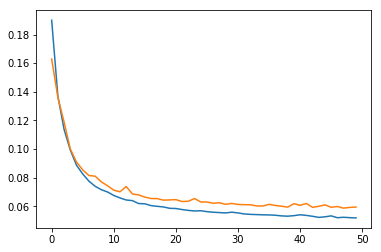

In [188]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

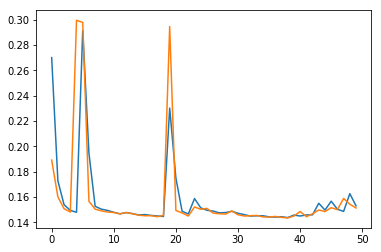

In [189]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

# So is it usable after all?

Unless we specifically know that the non-linearities are present - no. It adds some complexity to the model, but the selection process is simultaneous with learning. With the cost of compute rescaling the features manually after some fitting tests could be better is separated from the learning process (as with simple datasets we probably better would make use of some xgboosted trees on a larger share of features).